_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

In [1]:
# ! pip install category_encoders matplotlib==3.1.0

In [2]:
# Import data 

import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

In [3]:
# Import Libraries

%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
# Quick look at the data

df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0


In [5]:
# No null values... nice!

df.isnull().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

In [6]:
# Split data - train,val,test

train = df[ ((df.index.year>=2009) & (df.index.year <=2016)) |    # 2009-2016 bulk data
            ((df.index.year==2017) & (df.index.month <=6))  ]     # 2017 clipped to playoffs

val   = df[ ((df.index.year==2017) & (df.index.month >=10))  |    # 2017 data begin where season starts
            ((df.index.year==2018) & (df.index.month <=6))  ]     # 2018 clipped to playoffs

test  = df[ ((df.index.year==2018) & (df.index.month >=10))  |    # 2018 data begin where season starts
            ((df.index.year==2019) & (df.index.month <=6))  ]     # 2019 clipped to playoffs

print(train.shape, val.shape, test.shape)

(11081, 19) (1168, 19) (1709, 19)


In [7]:
# Get baseline accuracy using majority class 

majority_class = train['shot_made_flag'][0]
y_pred = [majority_class]*len(train)
y_train = train['shot_made_flag']
accuracy_score(y_train,y_pred)

0.5272087356736757

In [8]:
# Engineer Features

def wrangle(X):
    X = X.copy()
    
    # Engineer feature: homecourt advantage
    X['homecout_advantage'] = X['htm']=='GSW'
    
    # Engineer feature: opponent team
    def find_opp(row):
        if row['htm']=='GSW':
            return row['vtm']
        else:
            return row['htm']
    X['opponent_team'] = X.apply(find_opp, axis=1)
    
    # Engineer feature: seconds remaining in period
    X['seconds_remaining_in_period'] = X['minutes_remaining']*60 + X['seconds_remaining']
    
    # Engineer feature: seconds remaining in game
    X['seconds_remaining_in_game'] = (4 - X['period'])*(12*60) + X['seconds_remaining_in_period']
    
    # Engineer feature: made previous shot?
    X['made_previous_shot'] = X['shot_made_flag'].shift(1)
    X['made_previous_shot'].iloc[0] = 0.0
        
    return X

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

C:\Users\David\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
# Check wrangle function

train.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,homecout_advantage,opponent_team,seconds_remaining_in_period,seconds_remaining_in_game,made_previous_shot
game_date,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,0,GSW,HOU,Regular Season,2.0,True,HOU,685,2845,0.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,1,GSW,HOU,Regular Season,0.0,True,HOU,571,2731,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,0,GSW,HOU,Regular Season,-4.0,True,HOU,362,2522,1.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,0,GSW,HOU,Regular Season,-4.0,True,HOU,589,2029,0.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,0,GSW,HOU,Regular Season,0.0,True,HOU,139,1579,0.0


In [10]:
# Arrange data into X features matrix and y target vector

target = 'shot_made_flag'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [11]:
# Apply ordinal encoder

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.fit_transform(X_val)
X_test_encoded = encoder.fit_transform(X_test)

In [12]:
# Create RandomForest model

rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfc.fit(X_train_encoded, y_train);

In [13]:
# Get validation accuracy

y_pred_val = rfc.predict(X_val_encoded)
print('Validation Accuracy', accuracy_score(y_val, y_pred_val))

Validation Accuracy 0.5924657534246576


In [14]:
# Get test accuracy

y_pred_test = rfc.predict(X_test_encoded)
print('Validation Accuracy', accuracy_score(y_test, y_pred_test))

Validation Accuracy 0.6079578700994733


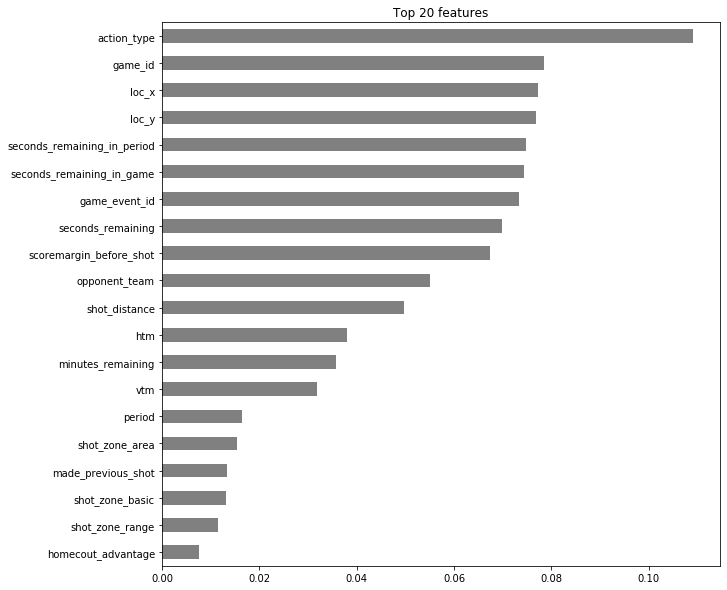

In [15]:
# Get feature importances

feature_names = encoder.transform(X_val).columns
importances = pd.Series(rfc.feature_importances_, feature_names)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [16]:
# Imaginary Confusion Matrix Calculations

cm = np.array([[85, 58], [8, 36]])

accuracy = (85+36) / (85+8+58+36)
precision_negative = (85)/(85+8)
precision_positive = (36)/(36+58)
recall_negative = (85)/(85+58)
recall_positive = (36)/(36+8)

f1_score_negative = (2*precision_negative*recall_negative) / (precision_negative+recall_negative)
f1_score_positive = (2*precision_positive*recall_positive) / (precision_positive+recall_positive)

print(cm)
print()
print("Accuracy: ", accuracy)
print("Precision negative: ", precision_negative)
print("Precision positive: ", precision_positive)
print("Recall negative: ", recall_negative)
print("Recall positive: ", recall_positive)
print("F1-score negative: ", f1_score_negative)
print("F1-score positive: ", f1_score_positive)

[[85 58]
 [ 8 36]]

Accuracy:  0.6470588235294118
Precision negative:  0.9139784946236559
Precision positive:  0.3829787234042553
Recall negative:  0.5944055944055944
Recall positive:  0.8181818181818182
F1-score negative:  0.7203389830508474
F1-score positive:  0.5217391304347826


In [17]:
# Get Confusion Matrix for Steph Curry shots 

cm = confusion_matrix(y_val, y_pred_val)
cm

array([[413, 190],
       [286, 279]], dtype=int64)

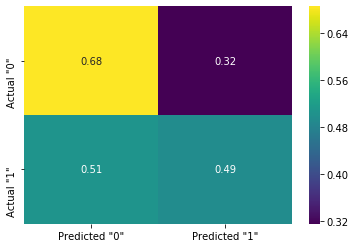

In [18]:
# Plot Confusion Matrix Heatmap for Steph Curry shots

def plot_confusion_matrix(y_true,y_pred,normalize=False):
    columns = [f'Predicted "{c}"' for c in unique_labels(y_true)]
    index_names = [f'Actual "{c}"' for c in unique_labels(y_true)]
    cm = confusion_matrix(y_val, y_pred)
    if normalize:
        cm = cm/cm.sum(axis=1).reshape(y_true.nunique(),1)
    df = pd.DataFrame(cm, columns = columns , index= index_names)
    sns.heatmap(df, cmap='viridis', annot=True, fmt='.2f');

plot_confusion_matrix(y_val, y_pred_val, True)

In [19]:
# Print Classification Report for Steph Curry Shots

print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.59      0.68      0.63       603
           1       0.59      0.49      0.54       565

    accuracy                           0.59      1168
   macro avg       0.59      0.59      0.59      1168
weighted avg       0.59      0.59      0.59      1168

